Training Step: 3829  | total loss: 0.31057 | time: 40.642s
| Adam | epoch: 010 | loss: 0.31057 - acc: 0.8680 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.31566 | time: 41.744s
| Adam | epoch: 010 | loss: 0.31566 - acc: 0.8640 | val_loss: 0.50085 - val_acc: 0.7940 -- iter: 24500/24500
--


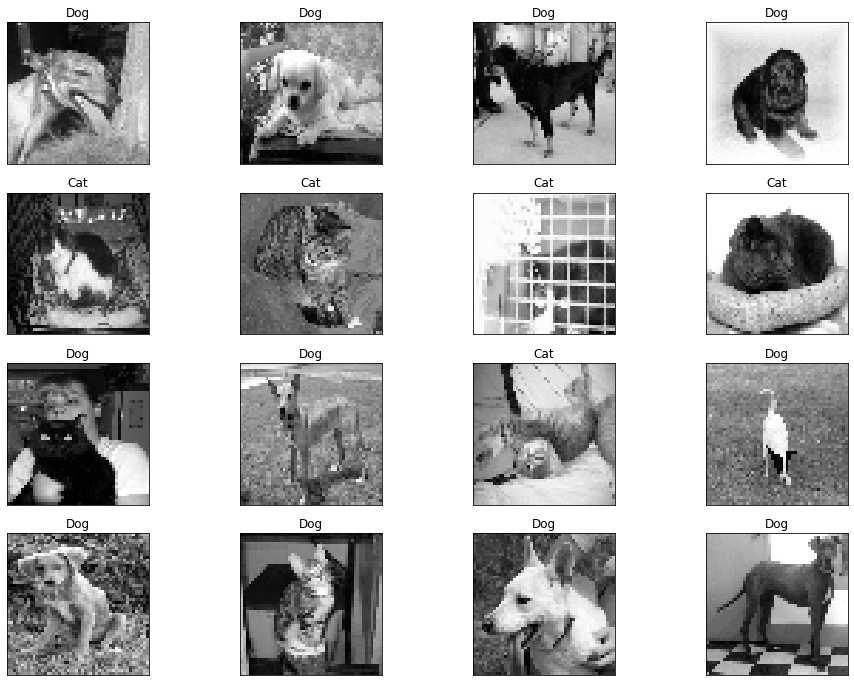

100%|██████████| 12500/12500 [00:19<00:00, 633.93it/s]


In [6]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

TRAIN_DIR = '/home/ayush/Downloads/train'
TEST_DIR = '/home/ayush/Downloads/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

def create_label(image_name):
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])
    
    
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
    
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

train_data = create_train_data()
test_data = create_test_data()

train = train_data[:-500]
test = train_data[-500:]
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet,0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_dir = 'log', tensorboard_verbose = 0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch = 10,
         validation_set = ({'input': X_test}, {'targets': y_test}),
         snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)

fig = plt.figure(figsize = (16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'
        
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))